# Projekt - KM3

Challenge 3 - blue and yellow circles

Question 1: Explain the Kandinsky Pattern in an algorithmic way, i.e. train a network which classifies Kandinsky Figures according to ground truth of challenge 3.

## Setup

In [ ]:
! pip install captum

     |████████████████████████████████| 1.4 MB 5.1 MB/s 


In [ ]:
import os
import torch
import torchvision
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from captum.attr import Lime, IntegratedGradients, KernelShap, visualization
from skimage import segmentation

if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

def masterSeed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp /content/drive/MyDrive/projekt-WB/explain.py ./explain.py
! cp /content/drive/MyDrive/projekt-WB/resnet18.py ./resnet18.py
! cp /content/drive/MyDrive/projekt-WB/train_function.py ./train_function.py
! git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns
! mv ./dat-kandinsky-patterns/challenge-nr-3/ ./dataset

folder = './dataset/counterfactual/'
for count, filename in enumerate(os.listdir(folder)):
    dst = filename + "_counterfactual.png"
    src =f"{folder}/{filename}"
    dst =f"{folder}/{dst}"
    os.rename(src, dst)

! rm -R ./dataset/false
! cp -r ./dataset/counterfactual/. ./dataset/false/
! rm -R ./dat-kandinsky-patterns
! mkdir ./counterf
! mv ./dataset/counterfactual/ ./counterf/counterfactual/

### Data

In [ ]:
def buildDatasetWithTransform(transform):
    dataset = torchvision.datasets.ImageFolder('./dataset', transform=transform)
    masterSeed(7)
    train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
    return train_set, test_set

dataset = buildDatasetWithTransform(
    torchvision.transforms.Compose([
        # zmiana rozmiaru, ponieważ batch wielkości 10 zajmował zbyt dużo pamięci 
        # na GPU (oryginały mają 600x600)
        torchvision.transforms.Resize((300, 300)),
        torchvision.transforms.ToTensor()
]))

train_set, test_set = dataset

In [ ]:
loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

### Model

In [ ]:
import torch.nn as nn
from resnet18 import ResNet18

model = torchvision.models.resnet18(pretrained = True)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/projekt-WB/standard_pretrained_resnet.model'))
model.eval()

## Wyjaśnienia

### Funkcje pomocnicze

In [ ]:
def show_img(idx):
  img, lab = test_set[idx]

  fig, ax = plt.subplots(figsize=(5,6))
  fig.suptitle('Image number ' + str(idx))

  ax.axis('off')
  ax.imshow(img.permute(1, 2, 0))
  ax.set_title('Label ' + str(lab) + '\nPredicted ' + str(model(img.unsqueeze(0)).max(1)[1].item()))

  plt.show()

In [ ]:
from itertools import product
from queue import Queue

def make_mask(img, bg=(0.5882353187, 0.5882353187, 0.5882353187), tolerance=(0.7, 0.7, 0.7), bg_tolerance=(0.5, 0.5, 0.5)):
  mask = -torch.ones(img.shape[1:])
  mask[(torch.abs(img[0]-bg[0])<bg_tolerance[0]) & (torch.abs(img[1]-bg[1])<bg_tolerance[1]) & (torch.abs(img[2]-bg[2])<bg_tolerance[1])] = 0

  mask_data = []

  def get_neighbours(x, y):
    res = []
    if x-1 > 0:
      res.append((x-1, y))
    if y-1 > 0 :
      res.append((x, y-1))
    if x+1 < img.shape[1]:
      res.append((x+1, y))
    if y+1 < img.shape[2]:
      res.append((x, y+1))
    return res

  def get_color(x, y):
    return float(img[0][x][y]), float(img[1][x][y]), float(img[2][x][y])

  def is_close(col1, col2):
    return all(np.absolute(np.array(col1) - np.array(col2)) < np.array(tolerance))

  def fill(x, y, color):
    start_color = get_color(x, y)
    start_x, start_y = x, y

    cluster_data = {}
    cluster_data['cluster_number'] = color
    cluster_data['color'] = start_color
    cluster_data['start_position_x'] = start_y
    cluster_data['start_position_y'] = start_x

    cluster_size = 1
    cluster_center = np.array([start_x, start_y])

    q = Queue()
    q.put((x, y))
    while not q.empty():
      x, y = q.get()

      cluster_size += 1
      cluster_center += np.array([x, y])

      if mask[x][y] < 0:
        mask[x][y] = color
      neighbours = get_neighbours(x, y)
      for nx, ny in neighbours:
        if is_close(get_color(nx, ny), start_color) and mask[nx][ny] == -1:
          q.put((nx, ny))
          mask[nx][ny] = -2
    
    cluster_data['size'] = cluster_size
    cluster_center = cluster_center/cluster_size
    cluster_data['center_x'] = cluster_center[1]
    cluster_data['center_y'] = cluster_center[0]
    return cluster_data

  i = 1
  for x, y in product(range(img.shape[1]), range(img.shape[2])):
    if mask[x][y] < 0:
      mask_data.append(fill(x, y, i))
      i+=1

  return torch.tensor(mask, dtype=torch.long), mask_data

In [ ]:
def comp_explanations(model, img, label, save_name=None):
  pred = model(img.unsqueeze(0)).max(1)[1].item()

  fig, axs = plt.subplots(2, 2, figsize=(12, 10))
  fig.suptitle(f'|Class:        {label}|Predicted:    {pred}|', fontsize=18)
  
  # Original Image
  axs[0][0].axis('off')
  im = axs[0][0].imshow(img.permute(1, 2, 0))
  axs[0][0].set_title('Original Image')
  print("Image done")

  # Mask
  mask, mask_data = make_mask(img)
  i = len(mask_data)
  axs[1][0].axis('off')
  im = axs[1][0].imshow(mask, cmap=my_cmap, vmin=0.001)
  axs[1][0].set_title(f'Mask ({i} groups)')
  print("Mask done")

  # IG
  explainer = IntegratedGradients(model)
  attr = explainer.attribute(img.unsqueeze(0), target=label)
  axs[0][1].axis('off')
  lim = max(attr[0].mean(axis=0).min().abs(), attr[0].mean(axis=0).max().abs())
  im = axs[0][1].imshow(attr[0].mean(axis=0), vmin=-lim, vmax=lim, cmap="RdBu")
  axs[0][1].set_title('IG')
  fig.colorbar(im, ax=axs[0][1])
  print("IG done")
  
  # SHAP
  explainer = KernelShap(model)
  attr = explainer.attribute(
      img.unsqueeze(0), 
      target=label, 
      baselines = (0.5882353187, 0.5882353187, 0.5882353187),
      n_samples=200, 
      feature_mask=mask,
      show_progress=False
  )
  attr = attr[0].mean(axis=0)
  axs[1][1].axis('off')
  im = axs[1][1].imshow(attr, vmin=-1, vmax=1, cmap="RdBu")
  axs[1][1].set_title('SHAP')
  fig.colorbar(im, ax=axs[1][1])
  print("SHAP done")

  print("All done")
  plt.show()
  if save_name is not None: plt.savefig(f'/content/drive/MyDrive/projekt-WB/{save_name}.png')

In [ ]:
def color_name(color):
  yellow = np.linalg.norm(np.array(color) - np.array((1, 1, 0)))
  blue = np.linalg.norm(np.array(color) - np.array ((0, 0, 1)))

  return 'yellow' if yellow < blue else 'blue'

def get_insight(idx, model):
  img, lab = test_set[idx]
  print(">>>", lab)
  mask, mask_data = make_mask(img)

  explainer = KernelShap(model)
  attr = explainer.attribute(
      img.unsqueeze(0), 
      target=lab, 
      baselines = (0.5882353187, 0.5882353187, 0.5882353187),
      n_samples=200, 
      feature_mask=mask,
      show_progress=False
  )
  attr = attr[0].mean(axis=0)
  for x, y in product(range(attr.shape[0]), range(attr.shape[1])):
    if mask[x][y]:
      mask_data[mask[x][y] - 1]['SHAP'] = float(attr[x][y])
  insight = pd.DataFrame(mask_data)
  insight['img_number'] = idx
  insight['circle_count'] = (insight['size']/156).round(0).astype(int)
  insight['color'] = insight.apply(lambda row: color_name(row['color']), axis = 1)
  insight['label'] = lab

  return insight

### Obrazki poglądowe

In [ ]:
my_cmap = cm.get_cmap('tab20')
my_cmap.set_under('black')

idx = 399
img, lab = test_set[idx]

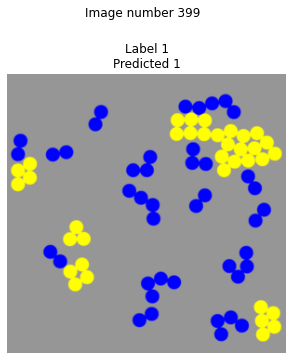

In [ ]:
show_img(idx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


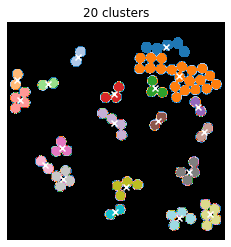

In [ ]:
mask, mask_data = make_mask(img)
i=len(mask_data)
df = pd.DataFrame(mask_data)
df['dots_count'] = df['size']/156

plt.imshow(mask, cmap=my_cmap, vmin=0.001)
plt.scatter(df['center_x'], df['center_y'], c='white', marker='x')
plt.title(f'{i} clusters')
plt.axis('off')
plt.show()

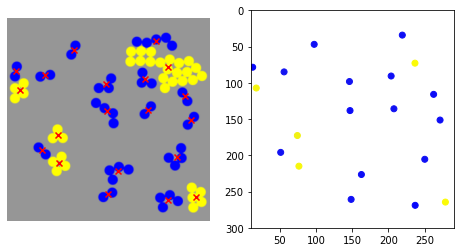

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

ax1.imshow(test_set[399][0].permute(1, 2, 0))
ax1.scatter(df['center_x'], df['center_y'], c='red', marker='x')
ax1.axis('off')

ax2.scatter(df['center_x'], df['center_y'], c=df['color'])
ax2.axis('equal')
ax2.axis([0, 300, 0, 300])
ax2.invert_yaxis()

plt.show()

### Wyjaśnienia

Image done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Mask done
IG done
SHAP done
All done


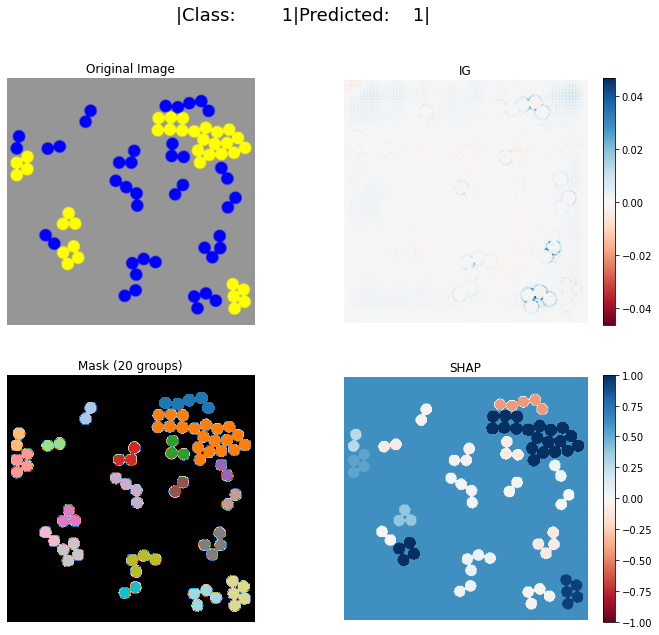

In [ ]:
comp_explanations(model, img, lab)

In [ ]:
dfs = []
for i in range(200):
  dfs.append(get_insight(i, model))

results = pd.concat(dfs, ignore_index=True)

>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


>>> 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
results.to_csv('/content/drive/MyDrive/projekt-WB/explanations.csv')
results

,cluster_number,color,start_position_x,start_position_y,size,center_x,center_y,SHAP,img_number,circle_count,label
0,1,yellow,115,5,2374,141.505476,34.556024,-1.460095,0,15,0
1,2,blue,186,20,629,192.993641,42.248013,0.128535,0,4,0
2,3,blue,133,54,625,119.531200,66.406400,1.471184,0,4,0
3,4,blue,72,64,309,76.391586,77.291262,-0.306096,0,2,0
4,5,blue,227,78,315,222.101587,85.980952,-0.005862,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
3997,17,blue,168,196,313,178.063898,205.322684,-0.062153,199,2,1
3998,18,yellow,165,210,952,152.173319,226.118697,1.135924,199,6,1
3999,19,blue,36,222,628,29.665605,234.390127,-0.007683,199,4,1
4000,20,blue,175,235,465,164.707527,250.729032,-0.052073,199,3,1


# Analiza wyjaśnień

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/projekt-WB/explanations.csv')
results

,Unnamed: 0,cluster_number,color,start_position_x,start_position_y,size,center_x,center_y,SHAP,img_number,circle_count,label
0,0,1,yellow,115,5,2374,141.505476,34.556024,-1.460095,0,15,0
1,1,2,blue,186,20,629,192.993641,42.248013,0.128535,0,4,0
2,2,3,blue,133,54,625,119.531200,66.406400,1.471184,0,4,0
3,3,4,blue,72,64,309,76.391586,77.291262,-0.306096,0,2,0
4,4,5,blue,227,78,315,222.101587,85.980952,-0.005862,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3997,3997,17,blue,168,196,313,178.063898,205.322684,-0.062153,199,2,1
3998,3998,18,yellow,165,210,952,152.173319,226.118697,1.135924,199,6,1
3999,3999,19,blue,36,222,628,29.665605,234.390127,-0.007683,199,4,1
4000,4000,20,blue,175,235,465,164.707527,250.729032,-0.052073,199,3,1


In [ ]:
results = pd.read_csv('/content/drive/MyDrive/projekt-WB/explanations.csv')
results

,Unnamed: 0,cluster_number,color,start_position_x,start_position_y,size,center_x,center_y,SHAP,img_number,circle_count,label
0,0,1,yellow,115,5,2374,141.505476,34.556024,-1.460095,0,15,0
1,1,2,blue,186,20,629,192.993641,42.248013,0.128535,0,4,0
2,2,3,blue,133,54,625,119.531200,66.406400,1.471184,0,4,0
3,3,4,blue,72,64,309,76.391586,77.291262,-0.306096,0,2,0
4,4,5,blue,227,78,315,222.101587,85.980952,-0.005862,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3997,3997,17,blue,168,196,313,178.063898,205.322684,-0.062153,199,2,1
3998,3998,18,yellow,165,210,952,152.173319,226.118697,1.135924,199,6,1
3999,3999,19,blue,36,222,628,29.665605,234.390127,-0.007683,199,4,1
4000,4000,20,blue,175,235,465,164.707527,250.729032,-0.052073,199,3,1


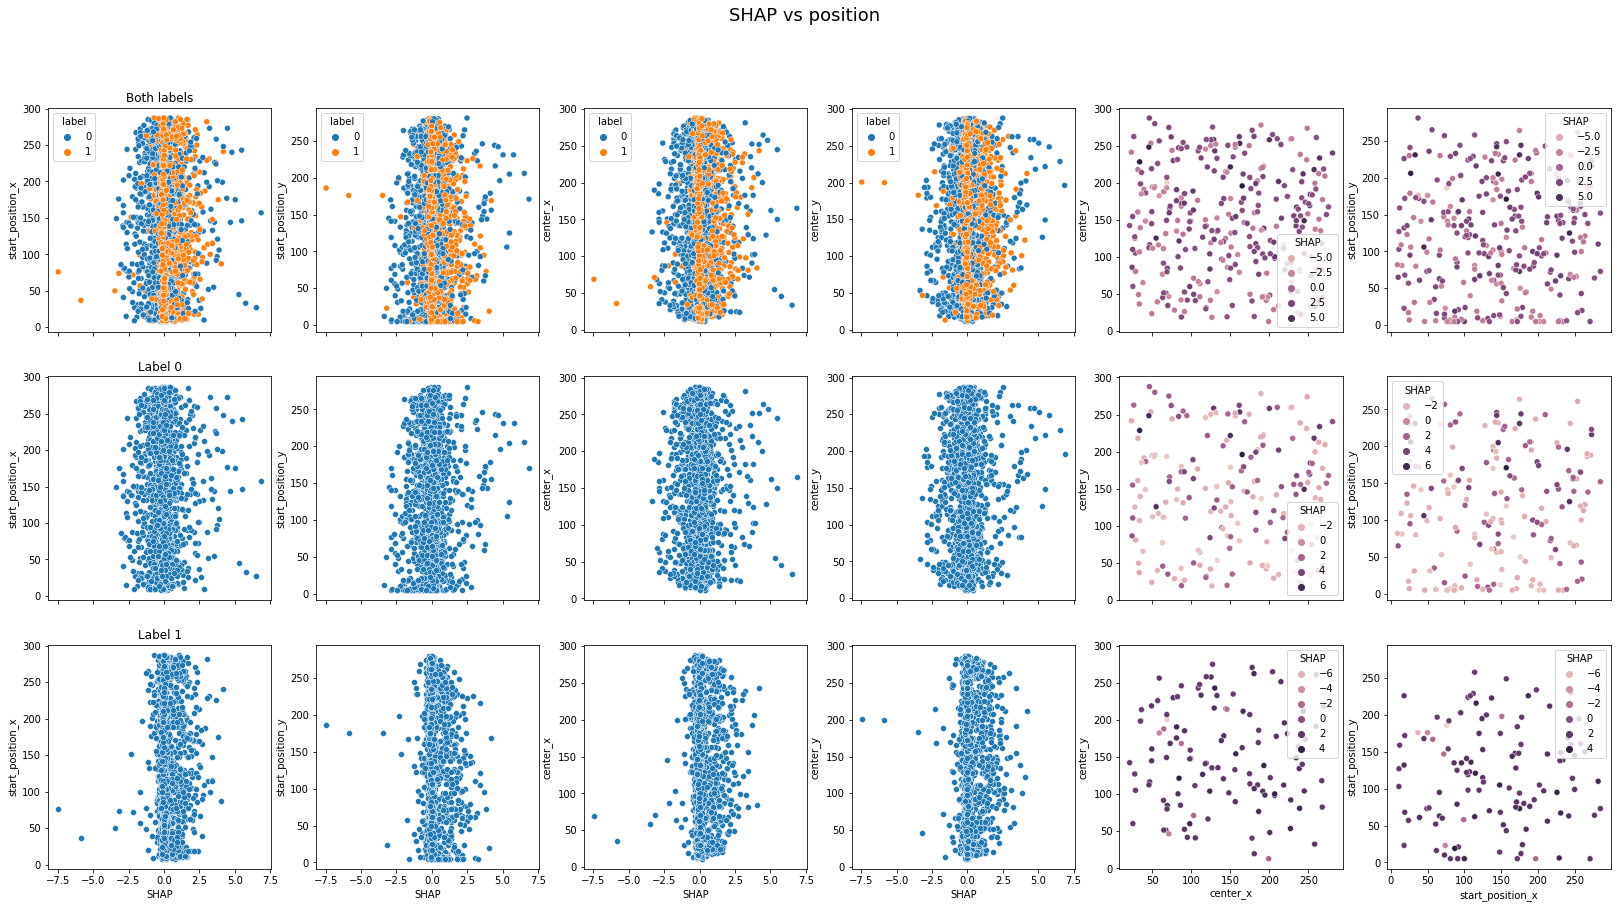

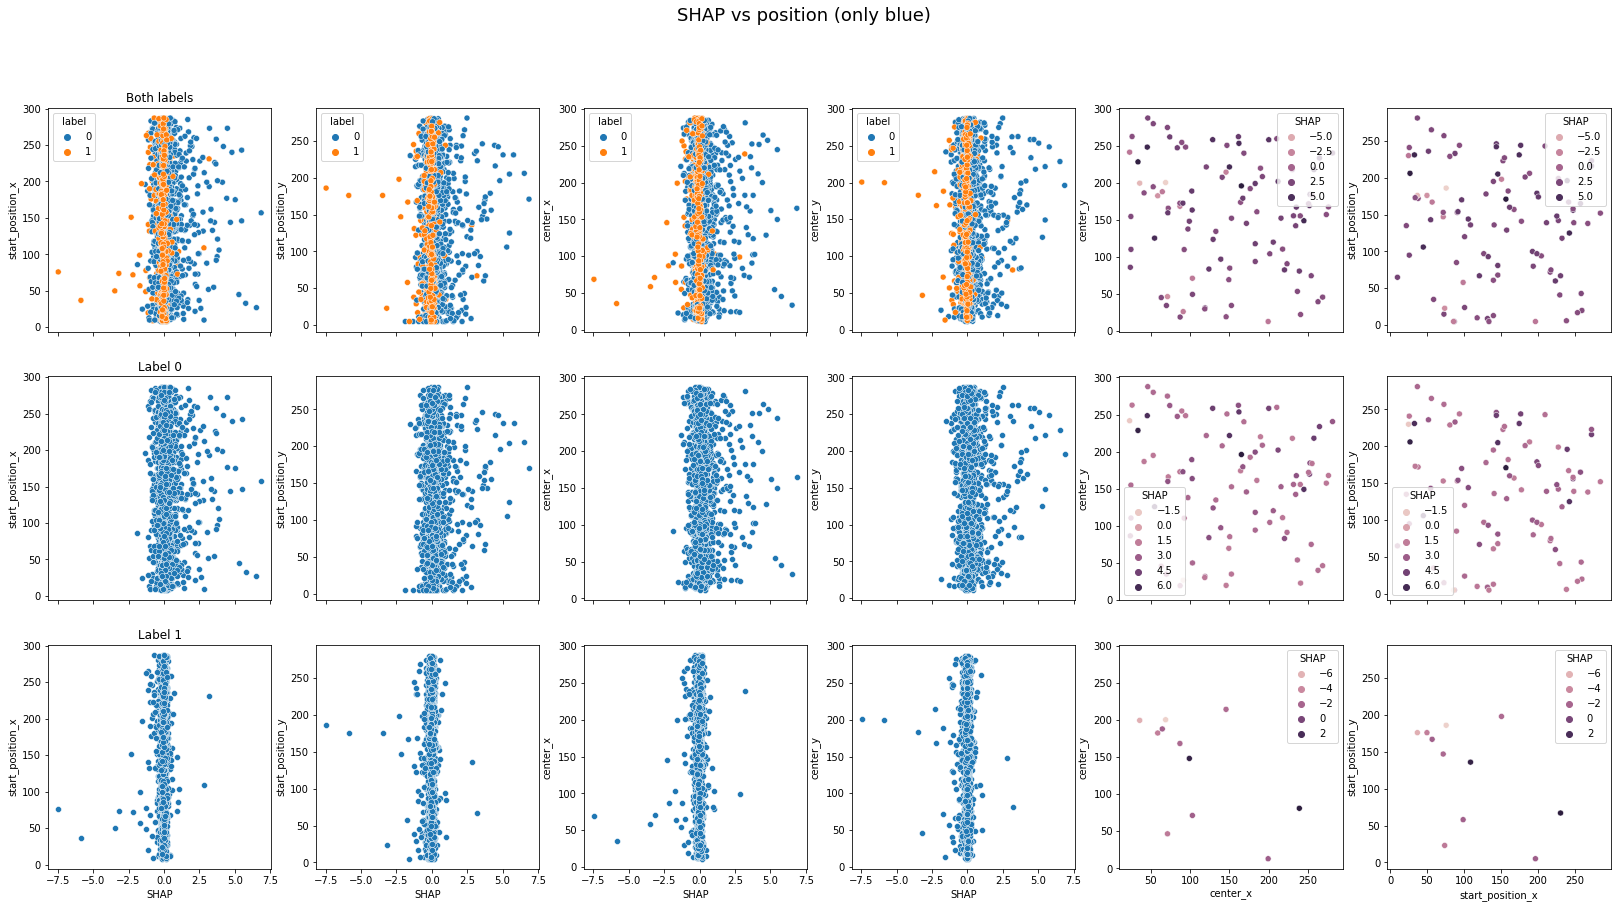

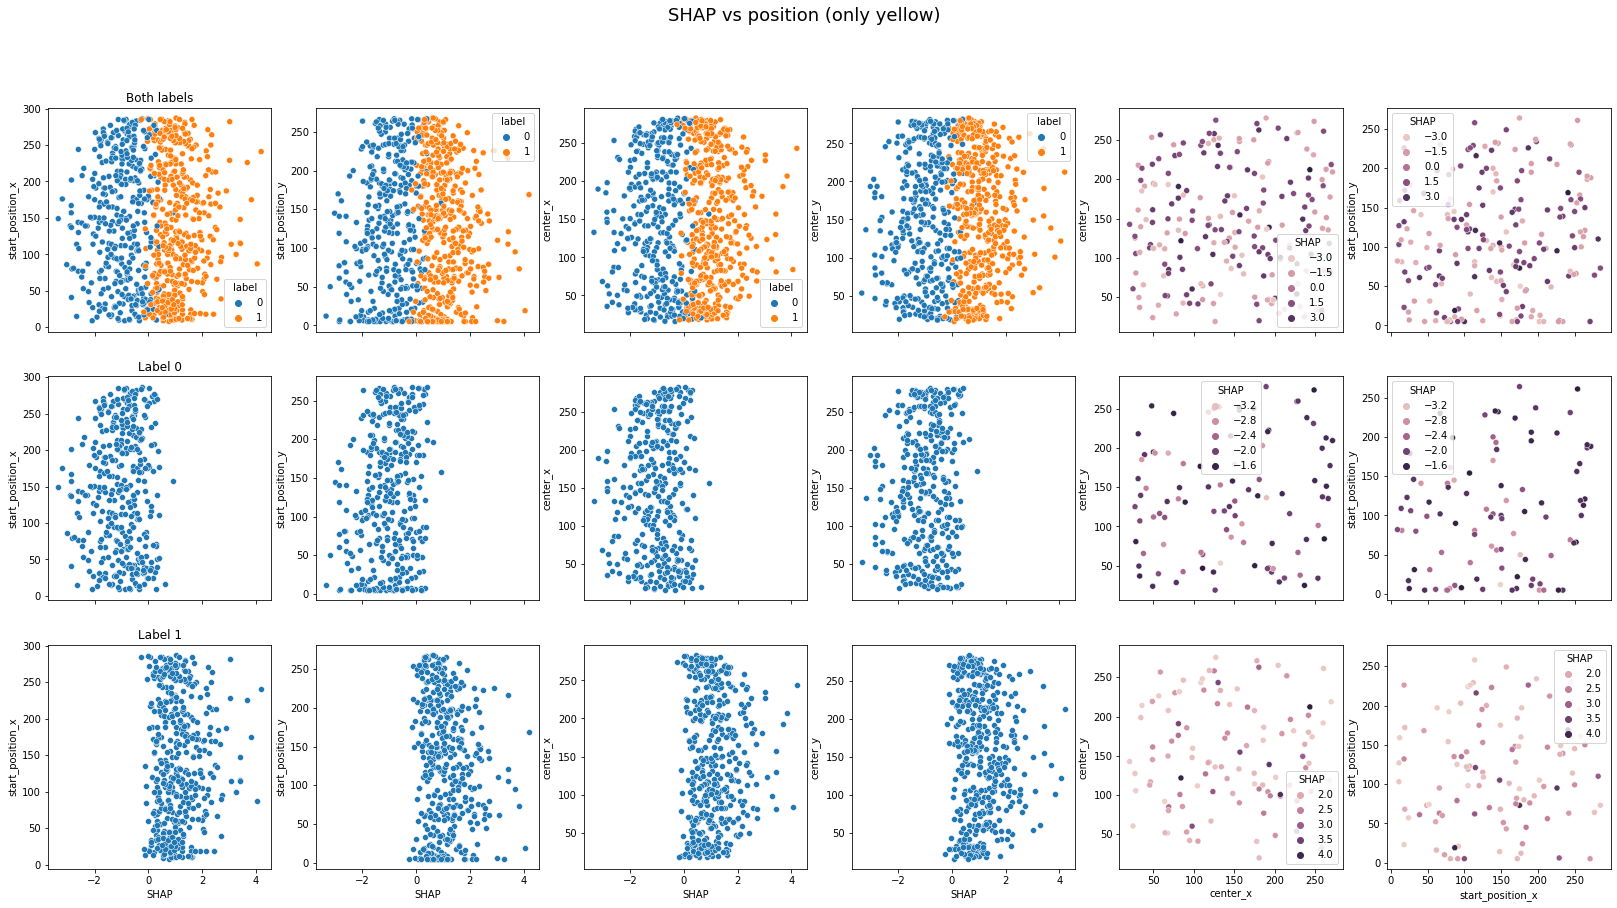

In [ ]:
def supersuperscatter(dat, title):
  fig, axs = plt.subplots(3, 6, figsize=(28, 14), sharex='col', sharey='col')
  fig.suptitle(title, fontsize=18)
  def superscatter(axId, dat, **kwargs):
    nonlocal axs
    sns.scatterplot(ax=axs[0, axId], data=dat, **{'hue': 'label', **kwargs})
    sns.scatterplot(ax=axs[1, axId], data=dat[dat.label == 0], **kwargs)
    sns.scatterplot(ax=axs[2, axId], data=dat[dat.label == 1], **kwargs)

  superscatter(0, dat, y='start_position_x', x='SHAP')
  superscatter(1, dat, y='start_position_y', x='SHAP')
  superscatter(2, dat, y='center_x', x='SHAP')
  superscatter(3, dat, y='center_y', x='SHAP')
  superscatter(4, dat[abs(dat.SHAP) > 1.5], x='center_x', y='center_y', hue='SHAP')
  superscatter(5, dat[abs(dat.SHAP) > 1.5], x='start_position_x', y='start_position_y', hue='SHAP')

  axs[0,0].set_title("Both labels")
  axs[1,0].set_title("Label 0")
  axs[2,0].set_title("Label 1")

supersuperscatter(results, 'SHAP vs position')
supersuperscatter(results[results.color == 'blue'], 'SHAP vs position (only blue)')
supersuperscatter(results[results.color == 'yellow'], 'SHAP vs position (only yellow)')

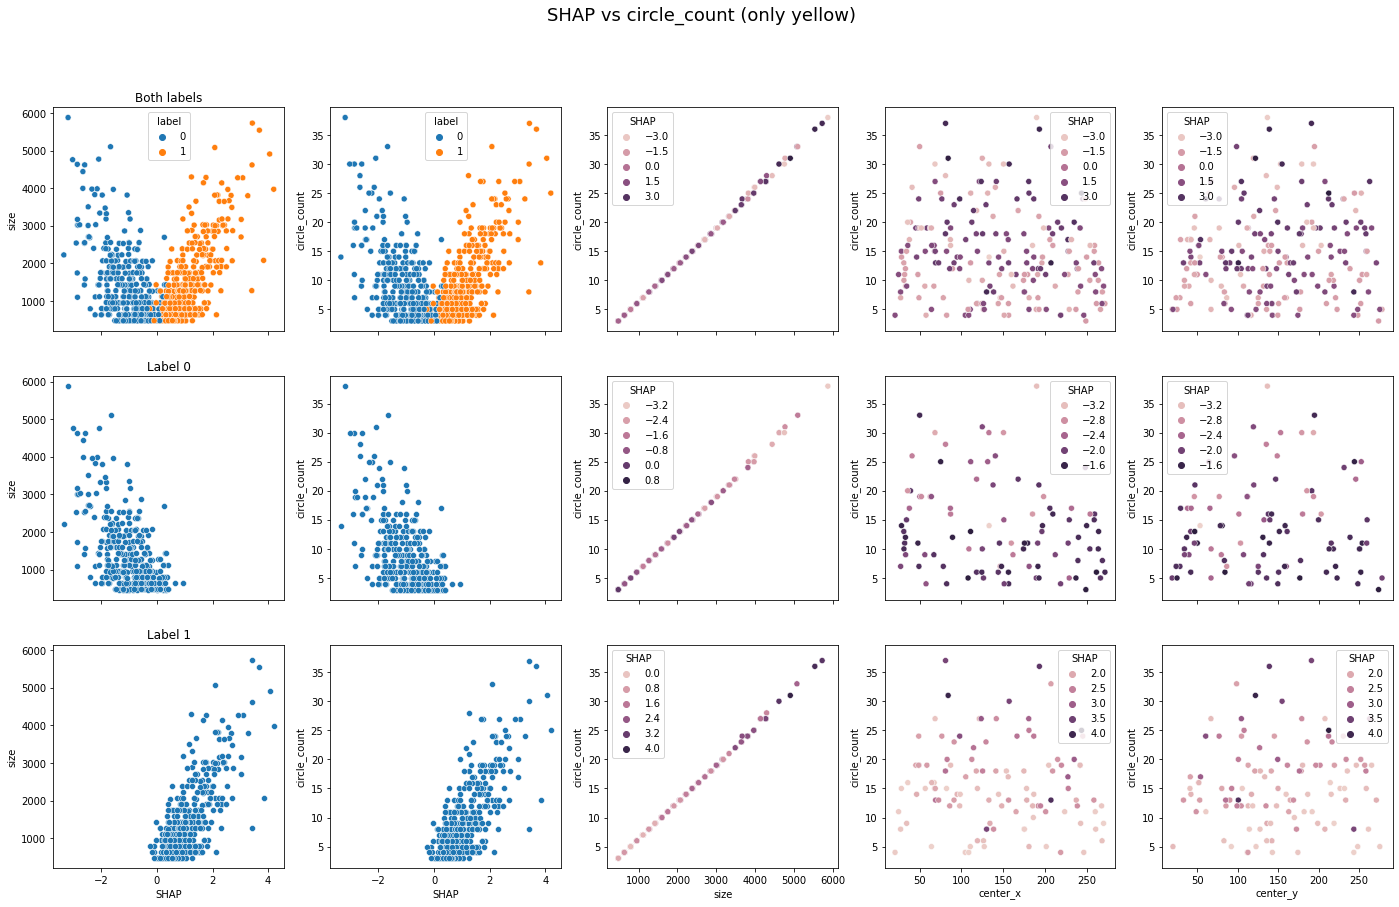

In [ ]:
def supersuperscatter(dat, title):
  fig, axs = plt.subplots(3, 5, figsize=(24, 14), sharex='col', sharey='col')
  fig.suptitle(title, fontsize=18)
  def superscatter(axId, dat, **kwargs):
    nonlocal axs
    sns.scatterplot(ax=axs[0, axId], data=dat, **{'hue': 'label', **kwargs})
    sns.scatterplot(ax=axs[1, axId], data=dat[dat.label == 0], **kwargs)
    sns.scatterplot(ax=axs[2, axId], data=dat[dat.label == 1], **kwargs)

  superscatter(0, dat, y='size', x='SHAP')
  superscatter(1, dat, y='circle_count', x='SHAP')
  superscatter(2, dat, x='size', y='circle_count', hue='SHAP')
  superscatter(3, dat[abs(dat.SHAP) > 1.5], x='center_x', y='circle_count', hue='SHAP')
  superscatter(4, dat[abs(dat.SHAP) > 1.5], x='center_y', y='circle_count', hue='SHAP')

  axs[0,0].set_title("Both labels")
  axs[1,0].set_title("Label 0")
  axs[2,0].set_title("Label 1")

supersuperscatter(results[results.color == 'yellow'], 'SHAP vs circle_count (only yellow)')

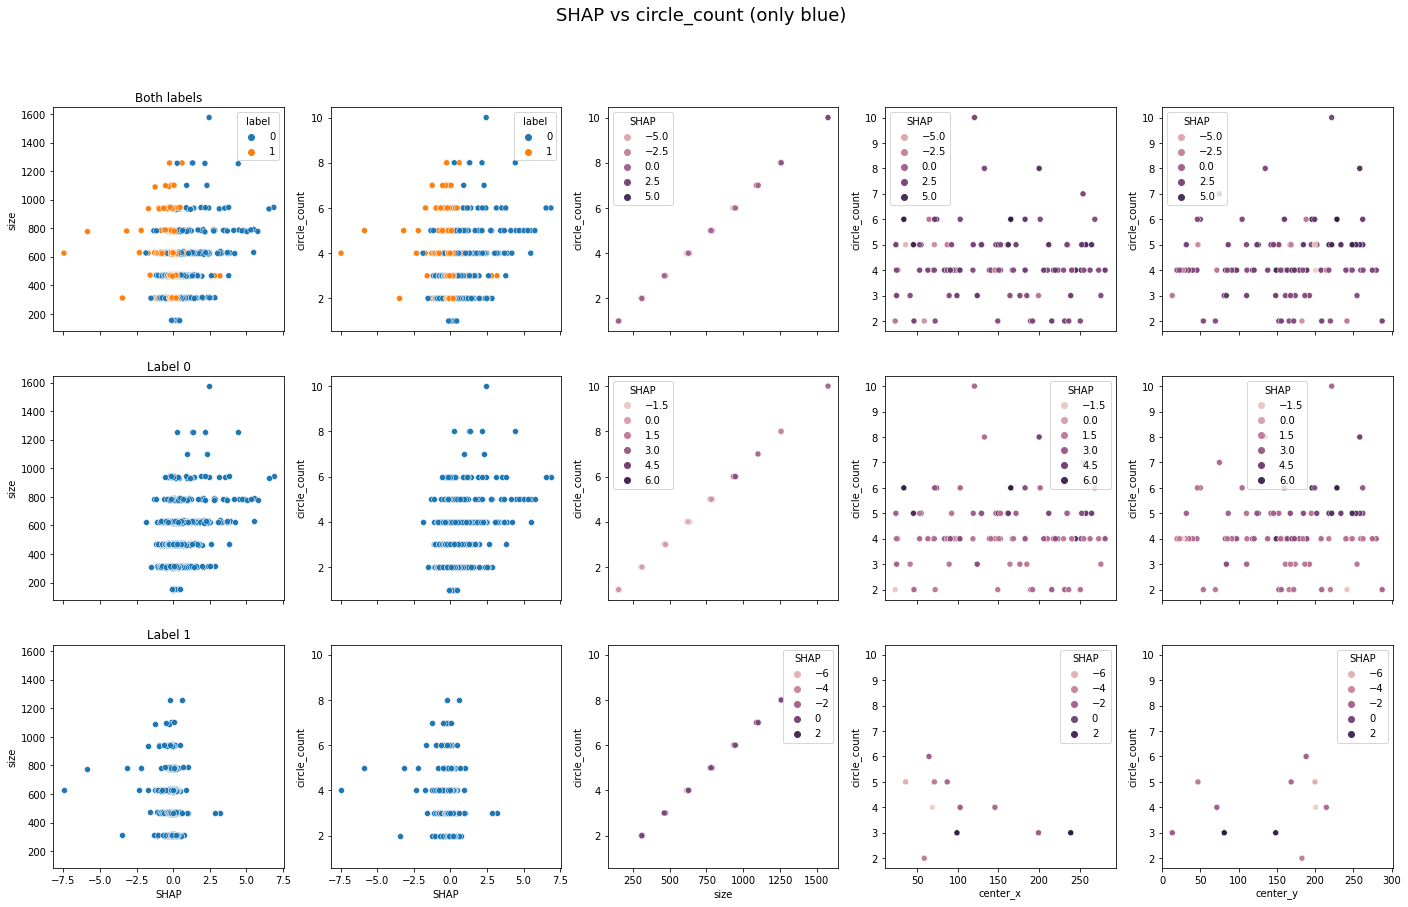

In [ ]:
def supersuperscatter(dat, title):
  fig, axs = plt.subplots(3, 5, figsize=(24, 14), sharex='col', sharey='col')
  fig.suptitle(title, fontsize=18)
  def superscatter(axId, dat, **kwargs):
    nonlocal axs
    sns.scatterplot(ax=axs[0, axId], data=dat, **{'hue': 'label', **kwargs})
    sns.scatterplot(ax=axs[1, axId], data=dat[dat.label == 0], **kwargs)
    sns.scatterplot(ax=axs[2, axId], data=dat[dat.label == 1], **kwargs)

  superscatter(0, dat, y='size', x='SHAP')
  superscatter(1, dat, y='circle_count', x='SHAP')
  superscatter(2, dat, x='size', y='circle_count', hue='SHAP')
  superscatter(3, dat[abs(dat.SHAP) > 1.5], x='center_x', y='circle_count', hue='SHAP')
  superscatter(4, dat[abs(dat.SHAP) > 1.5], x='center_y', y='circle_count', hue='SHAP')

  axs[0,0].set_title("Both labels")
  axs[1,0].set_title("Label 0")
  axs[2,0].set_title("Label 1")

supersuperscatter(results[results.color == 'blue'], 'SHAP vs circle_count (only blue)')

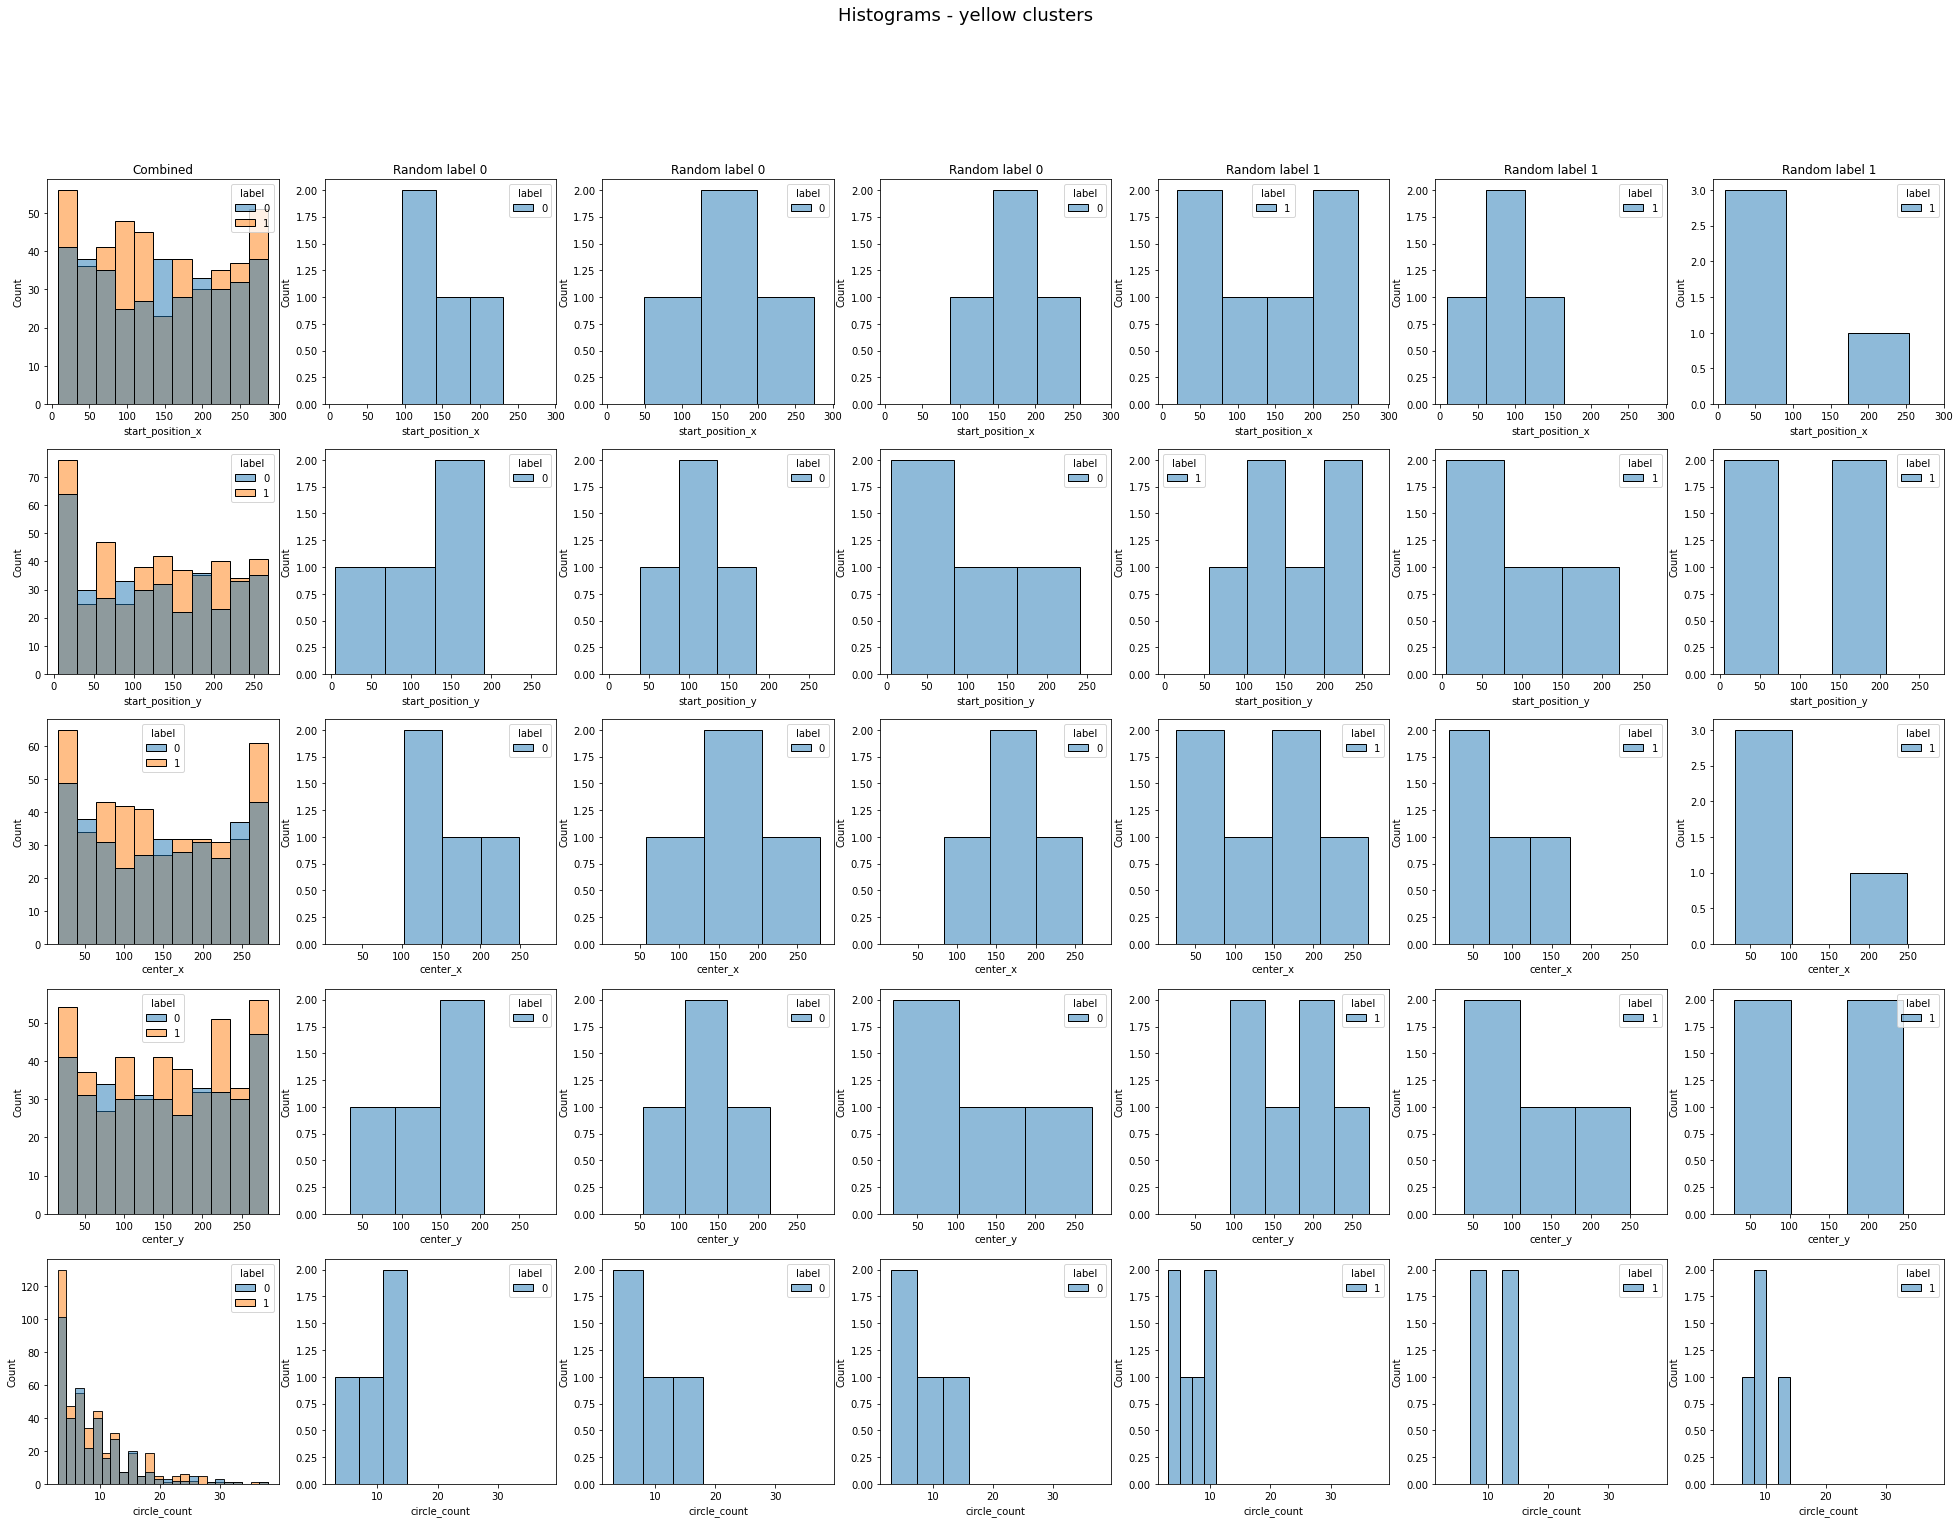

In [ ]:
def supersuperhist(dat, title):
  fig, axs = plt.subplots(5, 7, figsize=(34, 24), sharex='row')
  fig.suptitle(title, fontsize=18)
  rand_ind = [
    results.query('cluster_number == 1 and label == 0').reset_index().img_number[0],
    results.query('cluster_number == 1 and label == 0').reset_index().img_number[1],
    results.query('cluster_number == 1 and label == 0').reset_index().img_number[2],
    results.query('cluster_number == 1 and label == 1').reset_index().img_number[0],
    results.query('cluster_number == 1 and label == 1').reset_index().img_number[1],
    results.query('cluster_number == 1 and label == 1').reset_index().img_number[2]
  ]
  def superhist(axId, dat, **kwargs):
    nonlocal axs
    sns.histplot(ax=axs[axId, 0], data=dat, **{'hue': 'label', **kwargs})
    for i in range(len(rand_ind)):
      sns.histplot(ax=axs[axId, i+1], data=dat.query(f'img_number == {rand_ind[i]}'), **{'hue': 'label', **kwargs})

  superhist(0, dat, x='start_position_x')
  superhist(1, dat, x='start_position_y')
  superhist(2, dat, x='center_x')
  superhist(3, dat, x='center_y')
  superhist(4, dat, x='circle_count')

  axs[0,0].set_title("Combined")
  axs[0,1].set_title("Random label 0")
  axs[0,2].set_title("Random label 0")
  axs[0,3].set_title("Random label 0")
  axs[0,4].set_title("Random label 1")
  axs[0,5].set_title("Random label 1")
  axs[0,6].set_title("Random label 1")

supersuperhist(results[results.color == 'yellow'], 'Histograms - yellow clusters')

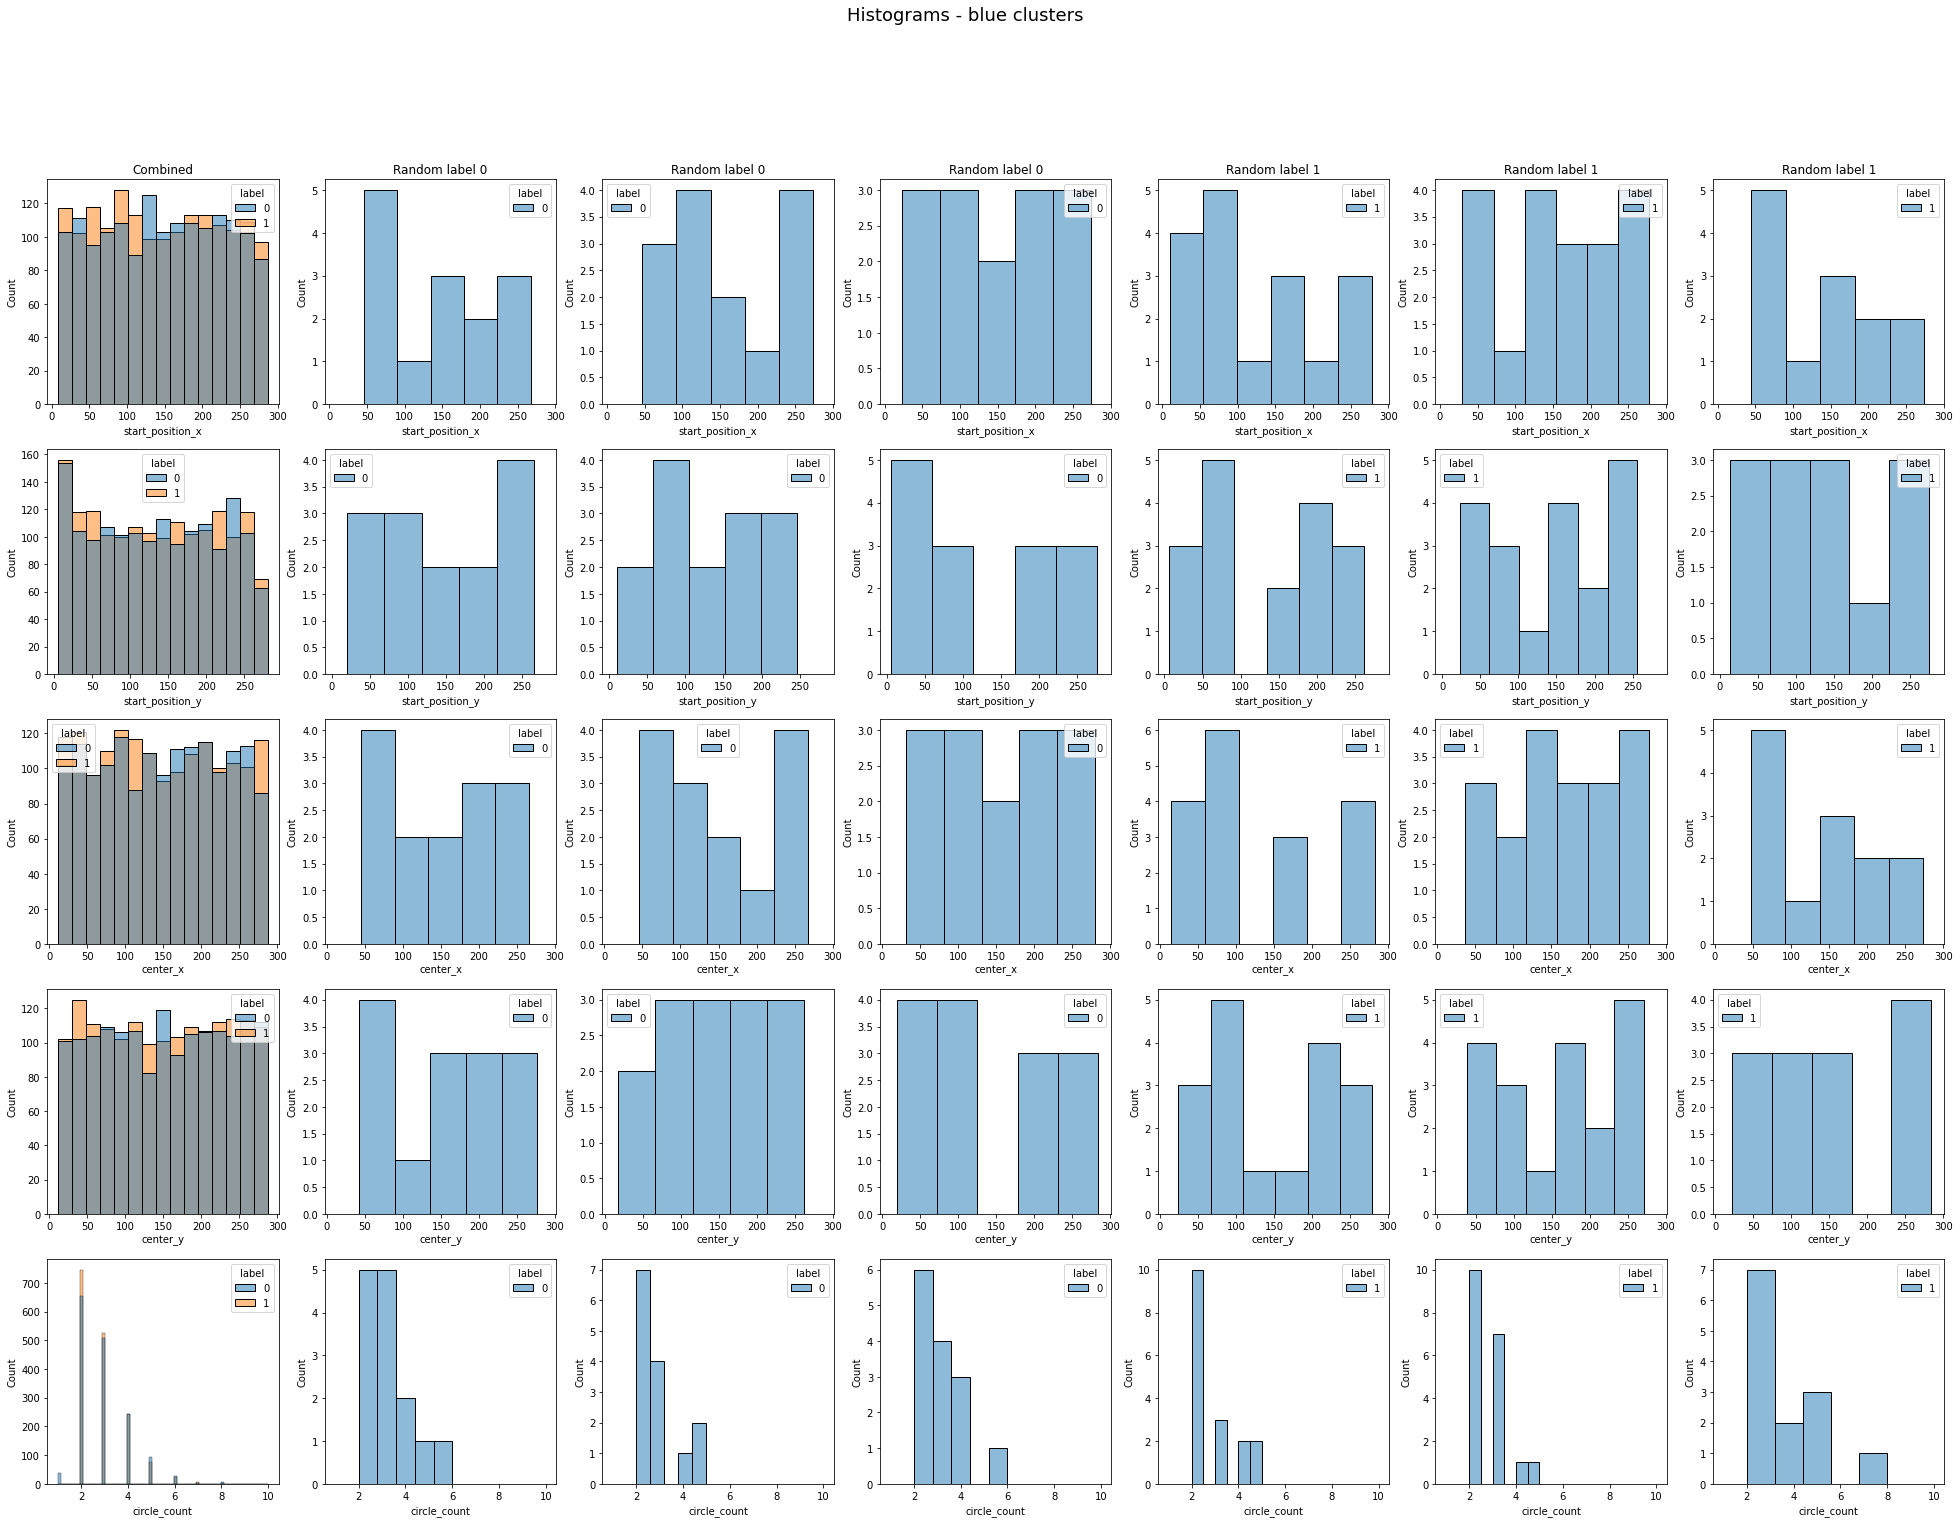

In [ ]:
def supersuperhist(dat, title):
  fig, axs = plt.subplots(5, 7, figsize=(34, 24), sharex='row')
  fig.suptitle(title, fontsize=18)
  rand_ind = [
    results.query('cluster_number == 1 and label == 0').reset_index().img_number[0],
    results.query('cluster_number == 1 and label == 0').reset_index().img_number[1],
    results.query('cluster_number == 1 and label == 0').reset_index().img_number[2],
    results.query('cluster_number == 1 and label == 1').reset_index().img_number[0],
    results.query('cluster_number == 1 and label == 1').reset_index().img_number[1],
    results.query('cluster_number == 1 and label == 1').reset_index().img_number[2]
  ]
  def superhist(axId, dat, **kwargs):
    nonlocal axs
    sns.histplot(ax=axs[axId, 0], data=dat, **{'hue': 'label', **kwargs})
    for i in range(len(rand_ind)):
      sns.histplot(ax=axs[axId, i+1], data=dat.query(f'img_number == {rand_ind[i]}'), **{'hue': 'label', **kwargs})

  superhist(0, dat, x='start_position_x')
  superhist(1, dat, x='start_position_y')
  superhist(2, dat, x='center_x')
  superhist(3, dat, x='center_y')
  superhist(4, dat, x='circle_count')

  axs[0,0].set_title("Combined")
  axs[0,1].set_title("Random label 0")
  axs[0,2].set_title("Random label 0")
  axs[0,3].set_title("Random label 0")
  axs[0,4].set_title("Random label 1")
  axs[0,5].set_title("Random label 1")
  axs[0,6].set_title("Random label 1")

supersuperhist(results[results.color == 'blue'], 'Histograms - blue clusters')

## Oczekiwana struktura raportu końcowego

1. Abstract
2. Introduction
 * Aby lepiej zrozumieć działanie sieci neuronowych, musimy wiedzieć jak znajdować wyjaśnienia obrazków stworzonych wg. określonych, prostych zasad (przynajmniej pozornie prostych)
 * opis i pochodzenie Kandinsky Patterns
 * literatura -  co do tej pory udało się zrobić w kontekście Kandisnky Patterns? Jakie podejścia zastosowano? Na ile były one skuteczne? Inne sposoby wyjaśnień sieci konwolucyjnych. -> Artykuł wprowadzający challenge, drugi artykuł o Kandinsky (NSFR + YOLO), sposoby wyjaśnień
 * Przedstawienie problemu badawczego - próba wyjaśnienia challenge nr 3 i znalezienia ground truth + przykładowy obrazek
3. Methods
 * Wypróbowane architektury, najlepiej pretrenowane modele
 * Ostateczny wynik naszego modelu
 * Opis zastosowanych metod wyjaśnień + komentarz, że SHAP dawał najlepiej wyglądające wyniki
 * Nasze podejście do wyjaśnienia globalnego, każdy segment to jeden klaster i badaliśmy zależności w celu znalezienia ground truth.
4. Discussion
 * dyskusja wyników
 * jakie metody można jeszcze zastosować, np. sprawdzanie wartości SHAP dla każdego kółka wewnątrz klastra
5. Conclusion 
 * udało się znaleźć zależności/nie udało się
 * inna twórczość

# Przeczytane artykuły:

## Sanity Checks for Saliency Maps

https://arxiv.org/pdf/1810.03292.pdf

Patryk Tomaszewski

Autorzy tego artykułu postawili sobie za zadanie sprawdzenie jakości wyników zwracanych przez różne metody wyjaśnień modeli. Poprzez przywołania detekcji krawędzi jako przykład postulują, że sama inspekcja wizualna przez użytkownika jest niewystarczająca aby ocenić przydatność wyjaśnienia oraz korelację ze strukturą modelu oraz zbiorem danych. Proponują metody mające na celu wyznaczenie tego poziomu korelacji poprzez losowe zmiany w wyjaśnianym modelu lub zbiorze danych, i porównaniu rożnicy w zwracanych wyjaśnieniach - jeżeli metoda wyjaśnień jest dobra, wynik powinien się znacząco różnić. Następnie przeprowadzają te testy na wielu różnych metodach wyjaśnień, dochodząc do wniosku że nie wszystkie z nich są wystarczająco wrażliwe na zmiany w modelu i danych aby mogły służyć jako narzędzie do wnioskowania o działaniu modelu.

## Transparency of Deep Neural Networks for Medical Image Analysis: A Review of Interpretability Methods


Adrian Stańdo



Autorzy artykułu przedstawili używane i znane dzisiaj metody wyjaśniania CNN. Podzielili oni techniki na 9 różnych kategorii i dla każdej z nich podali mocne i słabe strony. Wielką zaletą tego artykułu jest to, że przy każdej metodzie została zacytowana praca pokazująca zastosowanie danej metody z zakresu AI w medycynie. Praca ta daje czytelnikowi ogólne pojęcie o istniejących rozwiązaniach i pokazuje, z czego można skorzystać podczas swoich eksperymentów. Jedynym minusuem pracy jest to, że zawiera wiele tekstów i opisów, jeśli jednak czytelnik chciałby "zobaczyć" jak radzi sobie dana metoda, musi sięgać do kolejnych artykułów.




## Understanding of a convolutional neural network

https://ieeexplore.ieee.org/abstract/document/8308186

Krzysztof Wodnicki

W artykule szczegółowo została omówiona budowa konwolucyjnych sieci neuronwych. Autorzy przechodzą przez kolejne elementy wykorzystywane przy tworzeniu takiej sieci, opisują ich działanie i znaczenie w praktycznym użyciu modelu. Artykuł stanowi dobry materiał dla osób mających pierwszy kontakt z tematem. Niestety niektóre z załączonych obrazków są bardzo niskiej jakości, podobnie jak tłumaczenie na język angielski.